<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "6D"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/6D/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


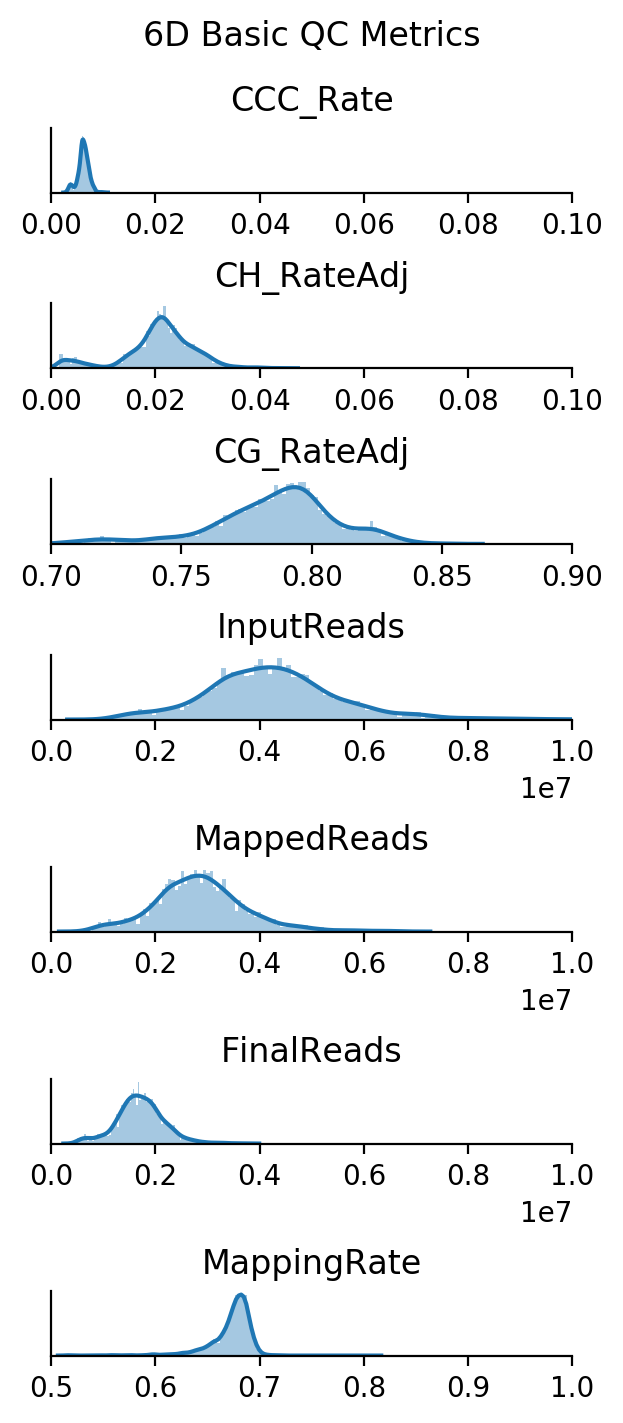

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

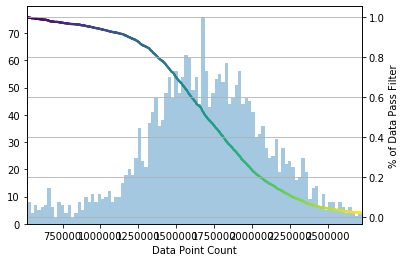

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2539/2539 (100.0%)
CG_RateAdj passed 2539/2539 (100.0%)
CH_RateAdj passed 2539/2539 (100.0%)
FinalReads passed 2539/2539 (100.0%)
MappingRate passed 2539/2539 (100.0%)
Overall passed 2539/2539 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
190131 1213
190205 1326


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 332 86.5%
ad002 342 89.1%
ad004 349 90.9%
ad006 332 86.5%
ad007 315 82.0%
ad008 333 86.7%
ad010 280 72.9%
ad012 256 66.7%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
6D_M_0,/gale/raidix/rdx-4/mapping/6D/CEMBA190131-6D-1...,0.007309,0.793494,0.791974,0.033335,0.026218,1378539.0,3228258,2177412.0,6D,...,6.824792,2.505024,16.756721,-24.682351,EP Adcy8,4.529855,-7.831366,14.625951,9.250955,True
6D_M_1,/gale/raidix/rdx-4/mapping/6D/CEMBA190131-6D-1...,0.007322,0.795799,0.794293,0.032647,0.025512,1753979.0,4183266,2822535.0,6D,...,7.794570,1.338088,14.521443,-25.308067,EP Adcy8,2.149319,-5.781720,7.964965,8.772627,True
6D_M_10,/gale/raidix/rdx-4/mapping/6D/CEMBA190131-6D-1...,0.007210,0.809486,0.808102,0.034665,0.027655,1471316.0,3425282,2281338.0,6D,...,-20.061903,-14.732301,-24.126775,-38.127907,CGE-Vip Ptprm,-7.509618,0.360238,-14.374852,9.012837,True
6D_M_100,/gale/raidix/rdx-4/mapping/6D/CEMBA190131-6D-1...,0.006974,0.800923,0.799525,0.030141,0.023330,834143.0,2208982,1419950.0,6D,...,-3.459492,7.458106,36.201990,-14.774408,OLF-Exc Sgcd,-1.193047,-0.117931,9.241523,18.644990,True
6D_M_1000,/gale/raidix/rdx-4/mapping/6D/CEMBA190131-6D-3...,0.007090,0.835446,0.834271,0.032802,0.025896,2247549.0,4821566,3278319.0,6D,...,21.761894,14.934169,32.165737,49.937060,L6b Nrp2,19.658373,-0.118587,2.317811,16.735888,True
6D_M_1002,/gale/raidix/rdx-4/mapping/6D/CEMBA190131-6D-3...,0.006012,0.789336,0.788061,0.025379,0.019483,1329176.0,2953154,1975743.0,6D,...,-5.521537,6.987280,34.979299,-7.449102,OLF-Exc Sgcd,-4.307920,-0.355754,9.589317,30.373212,True
6D_M_1003,/gale/raidix/rdx-4/mapping/6D/CEMBA190131-6D-3...,0.005444,0.764740,0.763452,0.020733,0.015373,1361128.0,3551362,1978459.0,6D,...,-0.334594,-7.165644,-39.049164,31.503103,IT-L23 Cux1,2.709874,1.991640,12.445620,15.635347,True
6D_M_1004,/gale/raidix/rdx-4/mapping/6D/CEMBA190131-6D-3...,0.006753,0.795141,0.793748,0.032103,0.025523,1721638.0,3998864,2692702.0,6D,...,6.573748,2.822777,17.192995,-24.711121,EP Adcy8,4.356933,-7.377501,12.982895,7.767799,True
6D_M_1005,/gale/raidix/rdx-4/mapping/6D/CEMBA190131-6D-3...,0.006504,0.806076,0.804806,0.032844,0.026513,2096484.0,4932104,3340507.0,6D,...,-28.808571,5.594926,2.957445,-21.404683,MGE-Pvalb Entpd3,1.946359,-3.666055,-0.597858,-26.872639,True
6D_M_1006,/gale/raidix/rdx-4/mapping/6D/CEMBA190131-6D-3...,0.005923,0.783981,0.782694,0.026734,0.020935,2358646.0,5573714,3755356.0,6D,...,1.780152,7.982069,12.397908,-41.124601,OLF-Exc Cux2,4.211724,-8.917059,-25.363418,-1.354902,True
